In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional
import hashlib

# Configuração para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Ambiente com Perceção Contínua

Vamos criar um ambiente onde o agente percebe distâncias às paredes em vez de números de estados.

In [2]:
class ContinuousPerceptionEnvironment:
    """Ambiente onde o agente percebe distâncias contínuas às paredes."""
    
    def __init__(self, grid_size: int = 10, max_perception_distance: float = 10.0):
        self.grid_size = grid_size
        self.max_perception_distance = max_perception_distance
        self.n_states = grid_size * grid_size
        self.goal_state = self.n_states
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        self.n_actions = len(self.actions)
        
        # Paredes conforme Figura 4
        self.walls = {4, 14, 24, 34, 44, 54, 64, 74, 84,  # Coluna 4
                     17, 27, 37, 47, 57, 67, 77, 87, 97}  # Coluna 7
        
        self.wall_penalty = -0.1
        self.goal_reward = 100.0
    
    def state_to_position(self, state: int) -> Tuple[int, int]:
        """Converte estado (1-100) para posição (linha, coluna)."""
        row = (state - 1) // self.grid_size
        col = (state - 1) % self.grid_size
        return row, col
    
    def position_to_state(self, row: int, col: int) -> int:
        """Converte posição (linha, coluna) para estado (1-100)."""
        return row * self.grid_size + col + 1
    
    def get_perception(self, state: int) -> Tuple[Optional[float], Optional[float], 
                                                   Optional[float], Optional[float]]:
        """Retorna perceção (UP, LEFT, DOWN, RIGHT) como distâncias às paredes.
        
        Retorna None se não há parede naquela direção dentro do alcance máximo.
        """
        row, col = self.state_to_position(state)
        perception = [None, None, None, None]  # UP, LEFT, DOWN, RIGHT
        
        # UP: procura parede acima
        for r in range(row - 1, -1, -1):
            check_state = self.position_to_state(r, col)
            if check_state in self.walls or r == 0:
                distance = (row - r) / self.grid_size  # Normalizado [0, 1]
                if distance * self.max_perception_distance <= self.max_perception_distance:
                    perception[0] = distance
                break
        
        # LEFT: procura parede à esquerda
        for c in range(col - 1, -1, -1):
            check_state = self.position_to_state(row, c)
            if check_state in self.walls or c == 0:
                distance = (col - c) / self.grid_size  # Normalizado [0, 1]
                if distance * self.max_perception_distance <= self.max_perception_distance:
                    perception[1] = distance
                break
        
        # DOWN: procura parede abaixo
        for r in range(row + 1, self.grid_size):
            check_state = self.position_to_state(r, col)
            if check_state in self.walls or r == self.grid_size - 1:
                distance = (r - row) / self.grid_size  # Normalizado [0, 1]
                if distance * self.max_perception_distance <= self.max_perception_distance:
                    perception[2] = distance
                break
        
        # RIGHT: procura parede à direita
        for c in range(col + 1, self.grid_size):
            check_state = self.position_to_state(row, c)
            if check_state in self.walls or c == self.grid_size - 1:
                distance = (c - col) / self.grid_size  # Normalizado [0, 1]
                if distance * self.max_perception_distance <= self.max_perception_distance:
                    perception[3] = distance
                break
        
        return tuple(perception)
    
    def transition(self, state: int, action: str) -> Tuple[int, float]:
        """Executa ação e retorna (novo_estado, recompensa)."""
        row, col = self.state_to_position(state)
        
        if action == 'UP':
            new_row, new_col = row - 1, col
        elif action == 'DOWN':
            new_row, new_col = row + 1, col
        elif action == 'LEFT':
            new_row, new_col = row, col - 1
        elif action == 'RIGHT':
            new_row, new_col = row, col + 1
        else:
            raise ValueError(f"Ação inválida: {action}")
        
        # Verifica se novo estado é válido
        if (new_row < 0 or new_row >= self.grid_size or 
            new_col < 0 or new_col >= self.grid_size):
            return state, self.wall_penalty
        
        new_state = self.position_to_state(new_row, new_col)
        
        if new_state in self.walls:
            return state, self.wall_penalty
        
        reward = self.goal_reward if new_state == self.goal_state else 0.0
        return new_state, reward
    
    def visualize_environment(self):
        """Visualiza o ambiente."""
        grid = np.zeros((self.grid_size, self.grid_size))
        
        for wall in self.walls:
            row, col = self.state_to_position(wall)
            grid[row, col] = -1
        
        goal_row, goal_col = self.state_to_position(self.goal_state)
        grid[goal_row, goal_col] = 2
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid, cmap='RdYlGn', interpolation='nearest')
        plt.colorbar(label='Tipo', ticks=[-1, 0, 2])
        
        for state in range(1, self.n_states + 1):
            row, col = self.state_to_position(state)
            color = 'white' if state in self.walls else 'black'
            plt.text(col, row, str(state), ha='center', va='center', 
                    fontsize=8, color=color, weight='bold')
        
        plt.title('Ambiente com Perceção Contínua\n-1: Parede, 0: Livre, 2: Objetivo', 
                 fontsize=14, weight='bold')
        plt.tight_layout()
        plt.show()

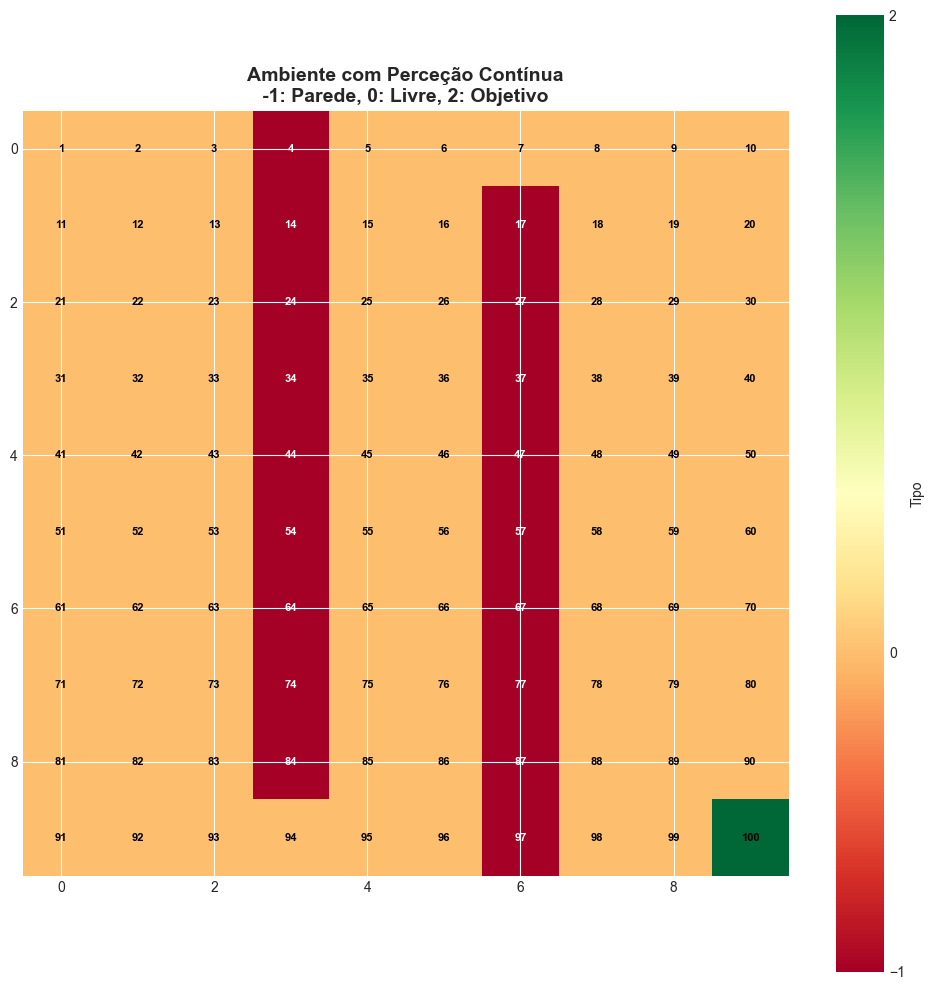

In [3]:
# Criar e visualizar ambiente
env = ContinuousPerceptionEnvironment()
env.visualize_environment()

## 2. Análise das Perceções

Vamos examinar as perceções de diferentes estados para entender o problema.

In [4]:
# Analisar perceções de alguns estados interessantes
interesting_states = [1, 3, 5, 8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83, 88, 93, 98]

print("="*80)
print("ANÁLISE DAS PERCEÇÕES DOS ESTADOS")
print("="*80)
print(f"{'Estado':<8} {'Posição':<12} {'UP':<10} {'LEFT':<10} {'DOWN':<10} {'RIGHT':<10}")
print("-"*80)

for state in interesting_states:
    row, col = env.state_to_position(state)
    perception = env.get_perception(state)
    
    def format_dist(d):
        return f"{d:.2f}" if d is not None else "NA"
    
    print(f"{state:<8} ({row},{col})      {format_dist(perception[0]):<10} "
          f"{format_dist(perception[1]):<10} {format_dist(perception[2]):<10} "
          f"{format_dist(perception[3]):<10}")

print("="*80)

ANÁLISE DAS PERCEÇÕES DOS ESTADOS
Estado   Posição      UP         LEFT       DOWN       RIGHT     
--------------------------------------------------------------------------------
1        (0,0)      NA         NA         0.90       0.30      
3        (0,2)      NA         0.20       0.90       0.10      
5        (0,4)      NA         0.10       0.90       0.50      
8        (0,7)      NA         0.40       0.90       0.20      
13       (1,2)      0.10       0.20       0.80       0.10      
18       (1,7)      0.10       0.10       0.80       0.20      
23       (2,2)      0.20       0.20       0.70       0.10      
28       (2,7)      0.20       0.10       0.70       0.20      
33       (3,2)      0.30       0.20       0.60       0.10      
38       (3,7)      0.30       0.10       0.60       0.20      
43       (4,2)      0.40       0.20       0.50       0.10      
48       (4,7)      0.40       0.10       0.50       0.20      
53       (5,2)      0.50       0.20       0.40     

## 3. Problema: Perceções Similares em Estados Diferentes

**Exemplo crítico**: Estados da coluna 3 e coluna 8 (mencionados no enunciado)
- Ambos têm paredes à esquerda e à direita
- As distâncias podem ser muito similares ou idênticas
- Isto cria **ambiguidade** no mapeamento estado → perceção

In [5]:
# Comparar estados das colunas 3 e 8 (índices 2 e 7)
print("\n" + "="*80)
print("COMPARAÇÃO: Coluna 3 vs Coluna 8")
print("="*80)
print(f"{'Estado':<8} {'Coluna':<8} {'Posição':<12} {'UP':<10} {'LEFT':<10} {'DOWN':<10} {'RIGHT':<10}")
print("-"*80)

for row in range(10):
    # Coluna 3 (índice 2)
    state_col3 = env.position_to_state(row, 2)
    perc_col3 = env.get_perception(state_col3)
    
    # Coluna 8 (índice 7)
    state_col8 = env.position_to_state(row, 7)
    perc_col8 = env.get_perception(state_col8)
    
    def format_dist(d):
        return f"{d:.2f}" if d is not None else "NA"
    
    print(f"{state_col3:<8} 3        ({row},2)      {format_dist(perc_col3[0]):<10} "
          f"{format_dist(perc_col3[1]):<10} {format_dist(perc_col3[2]):<10} "
          f"{format_dist(perc_col3[3]):<10}")
    
    print(f"{state_col8:<8} 8        ({row},7)      {format_dist(perc_col8[0]):<10} "
          f"{format_dist(perc_col8[1]):<10} {format_dist(perc_col8[2]):<10} "
          f"{format_dist(perc_col8[3]):<10}")
    
    # Verificar se perceções são idênticas
    if perc_col3 == perc_col8:
        print(f"  ⚠️  PERCEÇÕES IDÊNTICAS!")
    
    print("-"*80)

print("="*80)


COMPARAÇÃO: Coluna 3 vs Coluna 8
Estado   Coluna   Posição      UP         LEFT       DOWN       RIGHT     
--------------------------------------------------------------------------------
3        3        (0,2)      NA         0.20       0.90       0.10      
8        8        (0,7)      NA         0.40       0.90       0.20      
--------------------------------------------------------------------------------
13       3        (1,2)      0.10       0.20       0.80       0.10      
18       8        (1,7)      0.10       0.10       0.80       0.20      
--------------------------------------------------------------------------------
23       3        (2,2)      0.20       0.20       0.70       0.10      
28       8        (2,7)      0.20       0.10       0.70       0.20      
--------------------------------------------------------------------------------
33       3        (3,2)      0.30       0.20       0.60       0.10      
38       8        (3,7)      0.30       0.10       0.60 

## 4. Métodos de Discretização

Vamos explorar diferentes métodos para transformar perceções contínuas em índices discretos.

### 4.1. Método 1: Quantização Simples

Dividir o espaço contínuo em bins discretos.

In [6]:
class SimpleQuantizer:
    """Quantização simples de perceções contínuas."""
    
    def __init__(self, n_bins: int = 5):
        self.n_bins = n_bins
        self.bin_size = 1.0 / n_bins
    
    def quantize_value(self, value: Optional[float]) -> int:
        """Quantiza um único valor."""
        if value is None:
            return self.n_bins  # Bin especial para 'sem parede'
        bin_idx = min(int(value / self.bin_size), self.n_bins - 1)
        return bin_idx
    
    def perception_to_index(self, perception: Tuple) -> int:
        """Converte perceção para índice único."""
        quantized = [self.quantize_value(v) for v in perception]
        
        # Combina os 4 valores em um único índice
        # Cada direção pode ter (n_bins + 1) valores possíveis
        base = self.n_bins + 1
        index = (quantized[0] * base**3 + 
                quantized[1] * base**2 + 
                quantized[2] * base + 
                quantized[3])
        return index
    
    def max_index(self) -> int:
        """Retorna número máximo de índices possíveis."""
        return (self.n_bins + 1) ** 4

# Testar quantizador
quantizer = SimpleQuantizer(n_bins=5)

print("\n" + "="*80)
print(f"MÉTODO 1: QUANTIZAÇÃO SIMPLES ({quantizer.n_bins} bins)")
print("="*80)
print(f"Número máximo de índices: {quantizer.max_index()}")
print("-"*80)
print(f"{'Estado':<8} {'Perceção':<40} {'Índice':<10}")
print("-"*80)

for state in interesting_states[:10]:
    perception = env.get_perception(state)
    index = quantizer.perception_to_index(perception)
    print(f"{state:<8} {str(perception):<40} {index:<10}")

print("="*80)


MÉTODO 1: QUANTIZAÇÃO SIMPLES (5 bins)
Número máximo de índices: 1296
--------------------------------------------------------------------------------
Estado   Perceção                                 Índice    
--------------------------------------------------------------------------------
1        (None, None, 0.9, 0.3)                   1285      
3        (None, 0.2, 0.9, 0.1)                    1140      
5        (None, 0.1, 0.9, 0.5)                    1106      
8        (None, 0.4, 0.9, 0.2)                    1177      
13       (0.1, 0.2, 0.8, 0.1)                     60        
18       (0.1, 0.1, 0.8, 0.2)                     25        
23       (0.2, 0.2, 0.7, 0.1)                     270       
28       (0.2, 0.1, 0.7, 0.2)                     235       
33       (0.3, 0.2, 0.6, 0.1)                     264       
38       (0.3, 0.1, 0.6, 0.2)                     229       


### 4.2. Método 2: Hashing

Usar função hash para mapear perceções para índices.

In [7]:
class HashQuantizer:
    """Usa hashing para mapear perceções."""
    
    def __init__(self, table_size: int = 10000, precision: int = 2):
        self.table_size = table_size
        self.precision = precision
    
    def perception_to_index(self, perception: Tuple) -> int:
        """Converte perceção para índice usando hash."""
        # Arredonda valores para precisão especificada
        rounded = tuple(
            round(v, self.precision) if v is not None else None 
            for v in perception
        )
        
        # Usa hash do string representation
        hash_str = str(rounded)
        hash_value = int(hashlib.md5(hash_str.encode()).hexdigest(), 16)
        return hash_value % self.table_size
    
    def max_index(self) -> int:
        return self.table_size

# Testar hash quantizer
hash_quantizer = HashQuantizer(table_size=1000, precision=2)

print("\n" + "="*80)
print(f"MÉTODO 2: HASHING (table_size={hash_quantizer.table_size}, precision={hash_quantizer.precision})")
print("="*80)
print(f"Número máximo de índices: {hash_quantizer.max_index()}")
print("-"*80)
print(f"{'Estado':<8} {'Perceção':<40} {'Índice Hash':<15}")
print("-"*80)

for state in interesting_states[:10]:
    perception = env.get_perception(state)
    index = hash_quantizer.perception_to_index(perception)
    print(f"{state:<8} {str(perception):<40} {index:<15}")

print("="*80)


MÉTODO 2: HASHING (table_size=1000, precision=2)
Número máximo de índices: 1000
--------------------------------------------------------------------------------
Estado   Perceção                                 Índice Hash    
--------------------------------------------------------------------------------
1        (None, None, 0.9, 0.3)                   186            
3        (None, 0.2, 0.9, 0.1)                    391            
5        (None, 0.1, 0.9, 0.5)                    330            
8        (None, 0.4, 0.9, 0.2)                    83             
13       (0.1, 0.2, 0.8, 0.1)                     199            
18       (0.1, 0.1, 0.8, 0.2)                     980            
23       (0.2, 0.2, 0.7, 0.1)                     135            
28       (0.2, 0.1, 0.7, 0.2)                     502            
33       (0.3, 0.2, 0.6, 0.1)                     742            
38       (0.3, 0.1, 0.6, 0.2)                     187            


### 4.3. Método 3: Tile Coding

Técnica mais sofisticada que usa múltiplas camadas de quantização deslocadas.

In [8]:
class TileCoding:
    """Tile coding para discretização de estados contínuos."""
    
    def __init__(self, n_tilings: int = 4, n_tiles_per_dim: int = 5):
        self.n_tilings = n_tilings
        self.n_tiles_per_dim = n_tiles_per_dim
        self.tile_size = 1.0 / n_tiles_per_dim
        
        # Offsets para cada tiling
        self.offsets = [(i * self.tile_size / n_tilings, 
                        i * self.tile_size / n_tilings,
                        i * self.tile_size / n_tilings,
                        i * self.tile_size / n_tilings) 
                       for i in range(n_tilings)]
    
    def get_tile_index(self, value: Optional[float], offset: float) -> int:
        """Calcula índice do tile para um valor."""
        if value is None:
            return self.n_tiles_per_dim  # Tile especial
        shifted = (value + offset) % 1.0
        return min(int(shifted / self.tile_size), self.n_tiles_per_dim - 1)
    
    def perception_to_indices(self, perception: Tuple) -> List[int]:
        """Retorna lista de índices, um por tiling."""
        indices = []
        base = self.n_tiles_per_dim + 1
        
        for tiling_idx, offset in enumerate(self.offsets):
            tiles = [self.get_tile_index(perception[i], offset[i]) 
                    for i in range(4)]
            
            # Combina em índice único para este tiling
            index = (tiles[0] * base**3 + 
                    tiles[1] * base**2 + 
                    tiles[2] * base + 
                    tiles[3])
            
            # Adiciona offset baseado no tiling
            index += tiling_idx * (base ** 4)
            indices.append(index)
        
        return indices
    
    def max_index(self) -> int:
        base = self.n_tiles_per_dim + 1
        return self.n_tilings * (base ** 4)

# Testar tile coding
tile_coder = TileCoding(n_tilings=4, n_tiles_per_dim=5)

print("\n" + "="*80)
print(f"MÉTODO 3: TILE CODING ({tile_coder.n_tilings} tilings, {tile_coder.n_tiles_per_dim} tiles/dim)")
print("="*80)
print(f"Número máximo de índices: {tile_coder.max_index()}")
print("-"*80)
print(f"{'Estado':<8} {'Perceção':<40} {'Índices':<30}")
print("-"*80)

for state in interesting_states[:10]:
    perception = env.get_perception(state)
    indices = tile_coder.perception_to_indices(perception)
    print(f"{state:<8} {str(perception):<40} {str(indices[:2])+'...':<30}")

print("="*80)


MÉTODO 3: TILE CODING (4 tilings, 5 tiles/dim)
Número máximo de índices: 5184
--------------------------------------------------------------------------------
Estado   Perceção                                 Índices                       
--------------------------------------------------------------------------------
1        (None, None, 0.9, 0.3)                   [1285, 2581]...               
3        (None, 0.2, 0.9, 0.1)                    [1140, 2436]...               
5        (None, 0.1, 0.9, 0.5)                    [1106, 2402]...               
8        (None, 0.4, 0.9, 0.2)                    [1177, 2473]...               
13       (0.1, 0.2, 0.8, 0.1)                     [60, 1356]...                 
18       (0.1, 0.1, 0.8, 0.2)                     [25, 1321]...                 
23       (0.2, 0.2, 0.7, 0.1)                     [270, 1566]...                
28       (0.2, 0.1, 0.7, 0.2)                     [235, 1531]...                
33       (0.3, 0.2, 0.6, 0.1) 

## 5. Análise de Colisões

Vamos analisar quantos estados diferentes mapeiam para o mesmo índice (colisões).

In [9]:
def analyze_collisions(env, quantizer, quantizer_name: str):
    """Analisa colisões no mapeamento estado → índice."""
    
    index_to_states = {}
    
    # Mapeia todos os estados válidos
    for state in range(1, env.n_states + 1):
        if state not in env.walls:
            perception = env.get_perception(state)
            
            if isinstance(quantizer, TileCoding):
                # Tile coding retorna múltiplos índices, usa o primeiro
                index = quantizer.perception_to_indices(perception)[0]
            else:
                index = quantizer.perception_to_index(perception)
            
            if index not in index_to_states:
                index_to_states[index] = []
            index_to_states[index].append(state)
    
    # Estatísticas
    collision_counts = [len(states) for states in index_to_states.values()]
    n_unique_indices = len(index_to_states)
    n_valid_states = env.n_states - len(env.walls)
    max_collision = max(collision_counts)
    avg_collision = np.mean(collision_counts)
    
    # Encontra piores colisões
    worst_collisions = sorted(index_to_states.items(), 
                             key=lambda x: len(x[1]), 
                             reverse=True)[:5]
    
    print(f"\n{'='*80}")
    print(f"ANÁLISE DE COLISÕES: {quantizer_name}")
    print(f"{'='*80}")
    print(f"Estados válidos (não-parede): {n_valid_states}")
    print(f"Índices únicos utilizados: {n_unique_indices}")
    print(f"Taxa de compressão: {n_valid_states / n_unique_indices:.2f}x")
    print(f"Máximo de estados por índice: {max_collision}")
    print(f"Média de estados por índice: {avg_collision:.2f}")
    print(f"\nPiores colisões (top 5):")
    print("-"*80)
    
    for idx, (index, states) in enumerate(worst_collisions, 1):
        print(f"{idx}. Índice {index}: {len(states)} estados → {states[:10]}{'...' if len(states) > 10 else ''}")
    
    print("="*80)
    
    return index_to_states, collision_counts

# Analisar cada método
simple_map, simple_collisions = analyze_collisions(env, quantizer, "Quantização Simples")
hash_map, hash_collisions = analyze_collisions(env, hash_quantizer, "Hashing")
tile_map, tile_collisions = analyze_collisions(env, tile_coder, "Tile Coding")


ANÁLISE DE COLISÕES: Quantização Simples
Estados válidos (não-parede): 82
Índices únicos utilizados: 46
Taxa de compressão: 1.78x
Máximo de estados por índice: 6
Média de estados por índice: 1.78

Piores colisões (top 5):
--------------------------------------------------------------------------------
1. Índice 445: 6 estados → [42, 45, 48, 52, 55, 58]
2. Índice 480: 6 estados → [43, 46, 49, 53, 56, 59]
3. Índice 25: 3 estados → [12, 15, 18]
4. Índice 60: 3 estados → [13, 16, 19]
5. Índice 235: 3 estados → [22, 25, 28]

ANÁLISE DE COLISÕES: Hashing
Estados válidos (não-parede): 82
Índices únicos utilizados: 47
Taxa de compressão: 1.74x
Máximo de estados por índice: 4
Média de estados por índice: 1.74

Piores colisões (top 5):
--------------------------------------------------------------------------------
1. Índice 390: 4 estados → [30, 52, 55, 58]
2. Índice 187: 4 estados → [31, 32, 35, 38]
3. Índice 980: 3 estados → [12, 15, 18]
4. Índice 199: 3 estados → [13, 16, 19]
5. Índice 502:

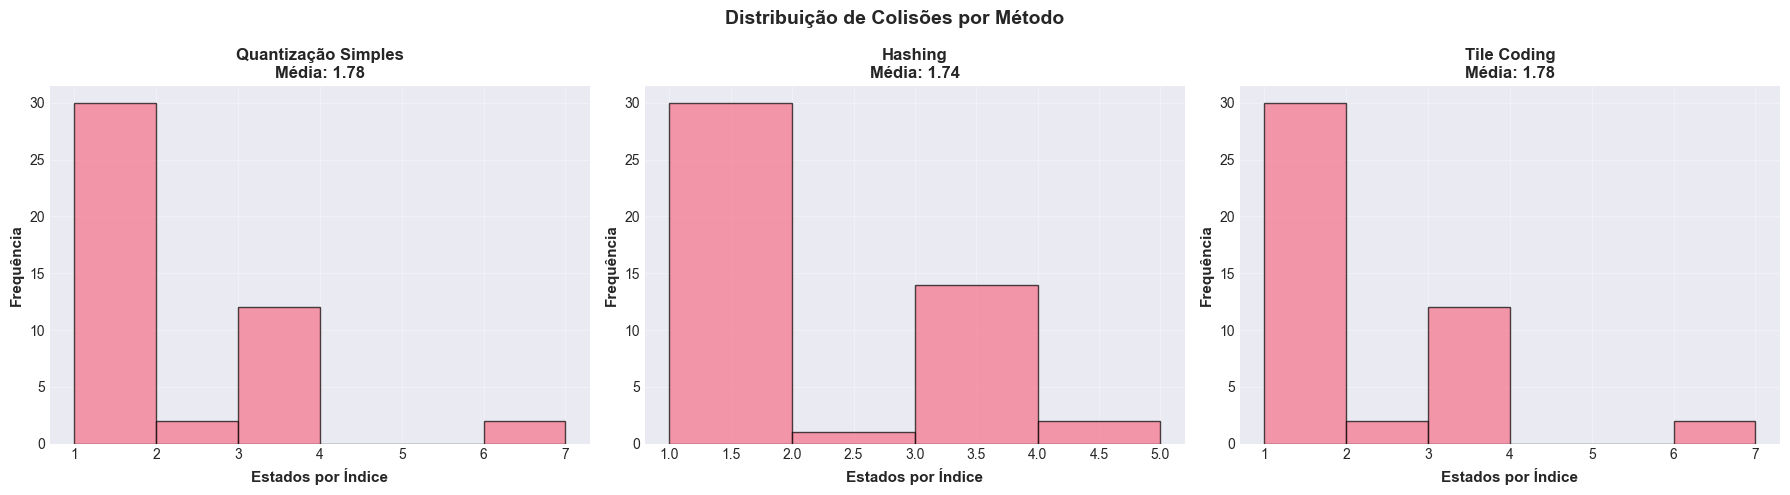

In [10]:
# Visualizar distribuição de colisões
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = [
    ("Quantização Simples", simple_collisions),
    ("Hashing", hash_collisions),
    ("Tile Coding", tile_collisions)
]

for idx, (name, collisions) in enumerate(methods):
    axes[idx].hist(collisions, bins=range(1, max(collisions) + 2), 
                   alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Estados por Índice', fontsize=11, weight='bold')
    axes[idx].set_ylabel('Frequência', fontsize=11, weight='bold')
    axes[idx].set_title(f'{name}\nMédia: {np.mean(collisions):.2f}', 
                       fontsize=12, weight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Distribuição de Colisões por Método', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

## 6. Verificação: Estados das Colunas 3 e 8

Vamos verificar especificamente o problema mencionado no enunciado.

In [11]:
def compare_columns(env, quantizer, col1: int, col2: int, name: str):
    """Compara mapeamento de duas colunas."""
    
    print(f"\n{'='*90}")
    print(f"COMPARAÇÃO DE COLUNAS {col1+1} e {col2+1}: {name}")
    print(f"{'='*90}")
    print(f"{'Linha':<6} {'Estado Col {col1+1}':<15} {'Estado Col {col2+1}':<15} "
          f"{'Índice Col {col1+1}':<15} {'Índice Col {col2+1}':<15} {'Colisão?':<10}")
    print("-"*90)
    
    collisions = 0
    
    for row in range(env.grid_size):
        state1 = env.position_to_state(row, col1)
        state2 = env.position_to_state(row, col2)
        
        # Pula se algum é parede
        if state1 in env.walls or state2 in env.walls:
            continue
        
        perc1 = env.get_perception(state1)
        perc2 = env.get_perception(state2)
        
        if isinstance(quantizer, TileCoding):
            idx1 = quantizer.perception_to_indices(perc1)[0]
            idx2 = quantizer.perception_to_indices(perc2)[0]
        else:
            idx1 = quantizer.perception_to_index(perc1)
            idx2 = quantizer.perception_to_index(perc2)
        
        collision = "SIM ⚠️" if idx1 == idx2 else "Não"
        if idx1 == idx2:
            collisions += 1
        
        print(f"{row:<6} {state1:<15} {state2:<15} {idx1:<15} {idx2:<15} {collision:<10}")
    
    print("-"*90)
    print(f"Total de colisões entre colunas: {collisions}")
    print(f"{'='*90}")
    
    return collisions

# Comparar colunas 3 e 8 (índices 2 e 7) para cada método
col1, col2 = 2, 7

simple_col_collisions = compare_columns(env, quantizer, col1, col2, "Quantização Simples")
hash_col_collisions = compare_columns(env, hash_quantizer, col1, col2, "Hashing")
tile_col_collisions = compare_columns(env, tile_coder, col1, col2, "Tile Coding")


COMPARAÇÃO DE COLUNAS 3 e 8: Quantização Simples
Linha  Estado Col {col1+1} Estado Col {col2+1} Índice Col {col1+1} Índice Col {col2+1} Colisão?  
------------------------------------------------------------------------------------------
0      3               8               1140            1177            Não       
1      13              18              60              25              Não       
2      23              28              270             235             Não       
3      33              38              264             229             Não       
4      43              48              480             445             Não       
5      53              58              480             445             Não       
6      63              68              474             439             Não       
7      73              78              690             655             Não       
8      83              88              900             865             Não       
9      93              

## 7. Visualização de Mapeamentos

Vamos visualizar como diferentes estados mapeiam para índices.

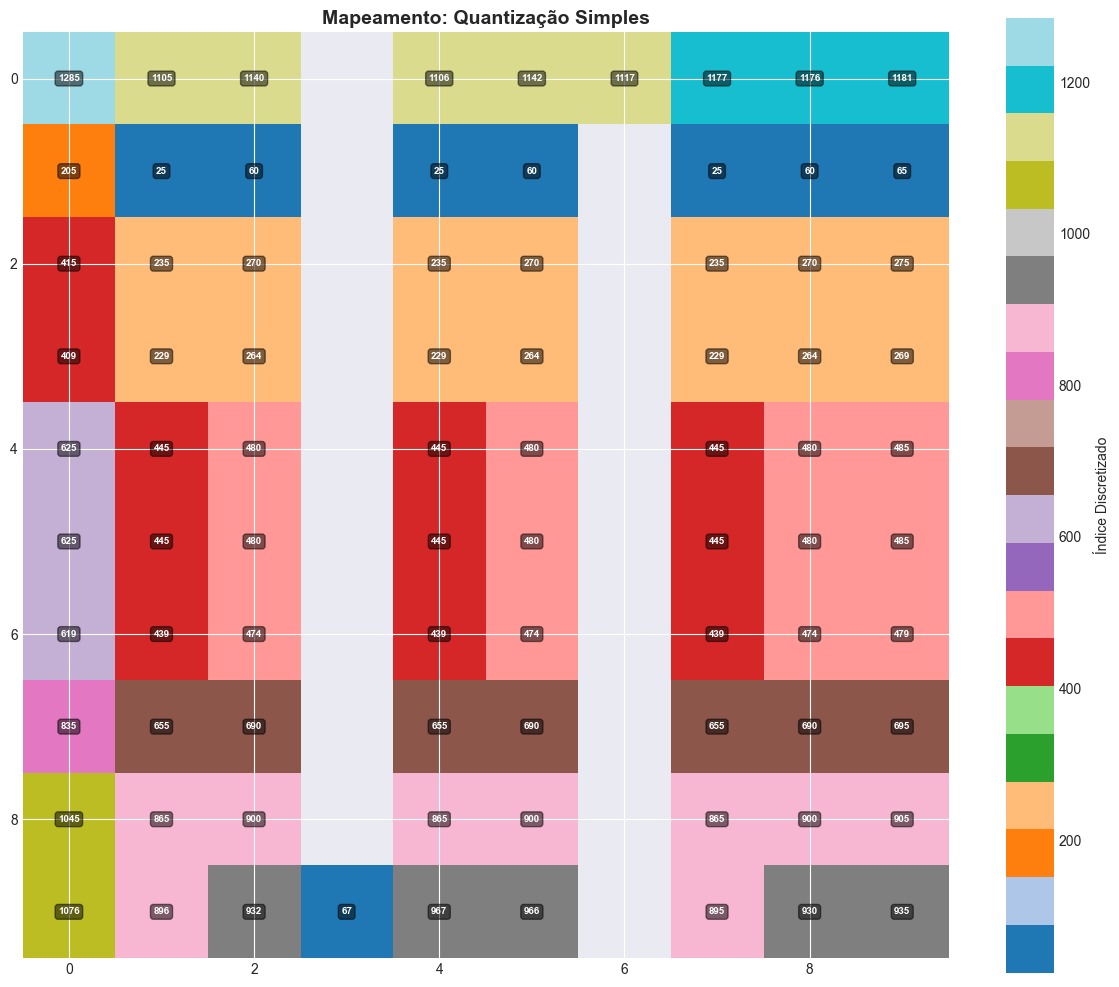

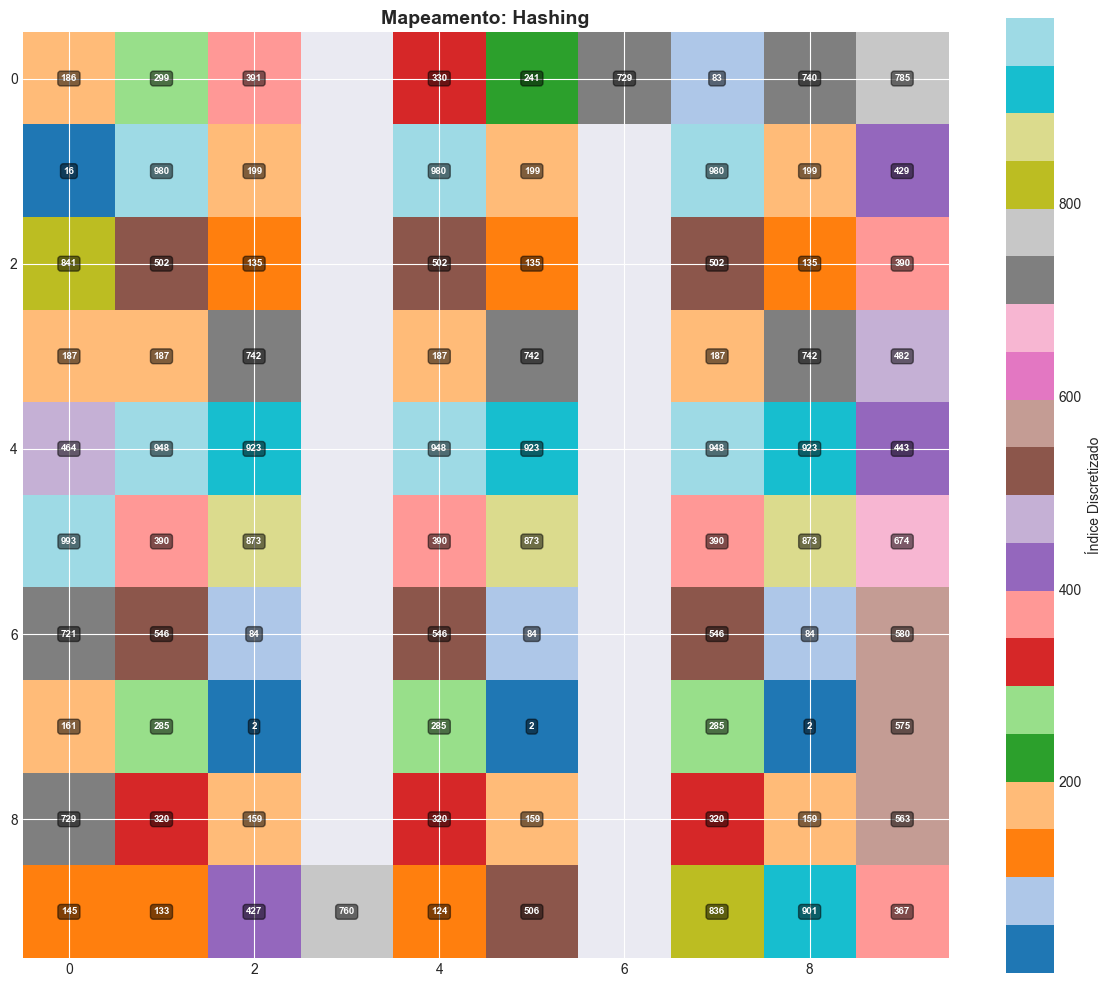

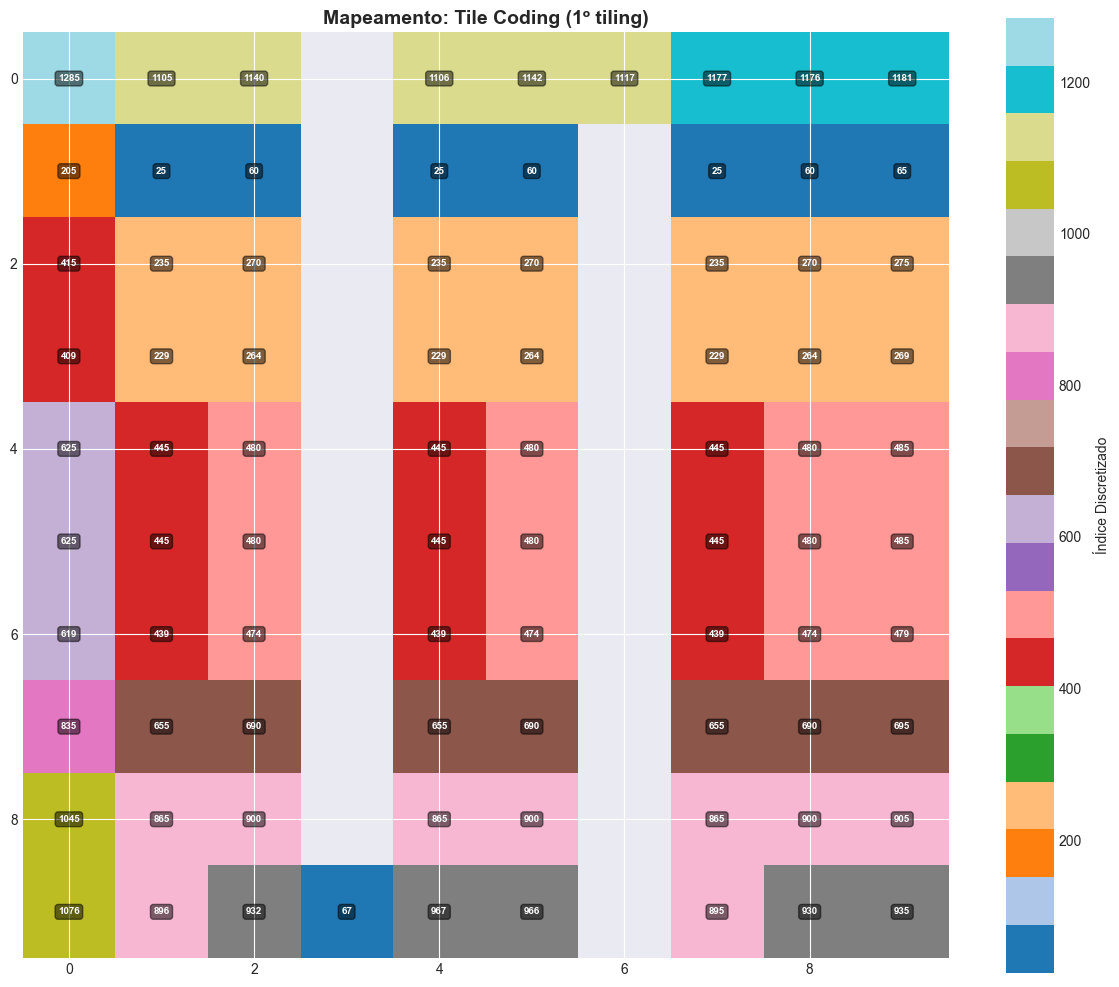

In [12]:
def visualize_mapping(env, quantizer, title: str):
    """Visualiza mapeamento estado → índice."""
    
    grid = np.full((env.grid_size, env.grid_size), np.nan)
    
    for state in range(1, env.n_states + 1):
        if state not in env.walls:
            row, col = env.state_to_position(state)
            perception = env.get_perception(state)
            
            if isinstance(quantizer, TileCoding):
                index = quantizer.perception_to_indices(perception)[0]
            else:
                index = quantizer.perception_to_index(perception)
            
            grid[row, col] = index
    
    plt.figure(figsize=(12, 10))
    im = plt.imshow(grid, cmap='tab20', interpolation='nearest')
    plt.colorbar(im, label='Índice Discretizado')
    
    # Adiciona números dos índices
    for state in range(1, env.n_states + 1):
        if state not in env.walls:
            row, col = env.state_to_position(state)
            index = int(grid[row, col])
            plt.text(col, row, str(index), ha='center', va='center',
                    fontsize=7, color='white', weight='bold',
                    bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

# Visualizar cada método
visualize_mapping(env, quantizer, "Mapeamento: Quantização Simples")
visualize_mapping(env, hash_quantizer, "Mapeamento: Hashing")
visualize_mapping(env, tile_coder, "Mapeamento: Tile Coding (1º tiling)")

## 8. Riscos e Problemas da Discretização

### 8.1. Perda de Informação
- Estados diferentes com perceções similares são mapeados para o mesmo índice
- O agente não consegue distinguir entre estes estados
- A política ótima pode ser impossível de aprender

### 8.2. Problema das Colunas 3 e 8
- Estados simétricos em relação às paredes têm perceções idênticas
- Exemplo: estado 3 e estado 8 podem ter a mesma distância às paredes laterais
- Ações ótimas podem ser diferentes, mas o agente vê o mesmo "estado"

### 8.3. Compromissos
- **Granularidade fina**: Mais índices, menos colisões, mas mais memória e tempo
- **Granularidade grossa**: Menos índices, mais colisões, mas mais eficiente
- **Hashing**: Aleatório, pode criar colisões inesperadas
- **Tile Coding**: Melhor generalização, mas mais complexo

## 9. Teste Prático: Q-Learning com Estados Discretizados

Vamos testar como o Q-Learning se comporta com perceções contínuas discretizadas.

In [13]:
class QLearningWithContinuousPerception:
    """Q-Learning usando perceções contínuas discretizadas."""
    
    def __init__(self, env, quantizer, alpha: float = 0.7, gamma: float = 0.99):
        self.env = env
        self.quantizer = quantizer
        self.alpha = alpha
        self.gamma = gamma
        
        # Tabela Q baseada em índices discretizados
        max_idx = quantizer.max_index()
        self.Q = np.zeros((max_idx, env.n_actions))
    
    def get_index(self, state: int) -> int:
        """Converte estado real para índice discretizado."""
        perception = self.env.get_perception(state)
        
        if isinstance(self.quantizer, TileCoding):
            return self.quantizer.perception_to_indices(perception)[0]
        else:
            return self.quantizer.perception_to_index(perception)
    
    def get_best_action(self, state: int) -> str:
        """Retorna melhor ação."""
        index = self.get_index(state)
        q_values = self.Q[index]
        max_q = np.max(q_values)
        best_actions = [i for i, q in enumerate(q_values) if q == max_q]
        best_action_idx = np.random.choice(best_actions)
        return self.env.actions[best_action_idx]
    
    def update_q(self, state: int, action: str, reward: float, next_state: int):
        """Atualiza valor Q."""
        index = self.get_index(state)
        next_index = self.get_index(next_state)
        action_idx = self.env.actions.index(action)
        
        current_q = self.Q[index, action_idx]
        max_next_q = np.max(self.Q[next_index])
        
        new_q = (1 - self.alpha) * current_q + self.alpha * (reward + self.gamma * max_next_q)
        self.Q[index, action_idx] = new_q
    
    def train(self, n_steps: int, greed: float = 0.9) -> List[float]:
        """Treina agente."""
        state = 1
        rewards = []
        
        for step in range(n_steps):
            # Escolhe ação
            if np.random.random() < greed:
                action = self.get_best_action(state)
            else:
                action = np.random.choice(self.env.actions)
            
            # Executa
            next_state, reward = self.env.transition(state, action)
            
            # Atualiza
            self.update_q(state, action, reward, next_state)
            
            rewards.append(reward)
            
            # Reset ou continua
            if next_state == self.env.goal_state:
                state = 1
            else:
                state = next_state
        
        return rewards
    
    def test_episode(self, max_steps: int = 1000) -> Tuple[int, float]:
        """Testa política."""
        state = 1
        total_reward = 0.0
        
        for step in range(max_steps):
            action = self.get_best_action(state)
            next_state, reward = self.env.transition(state, action)
            
            total_reward += reward
            
            if next_state == self.env.goal_state:
                return step + 1, total_reward
            
            state = next_state
        
        return max_steps, total_reward

In [14]:
# Treinar agentes com diferentes quantizadores
n_training_steps = 10000
n_experiments = 10

results = {}

quantizers = [
    ("Quantização Simples (5 bins)", SimpleQuantizer(n_bins=5)),
    ("Quantização Simples (10 bins)", SimpleQuantizer(n_bins=10)),
    ("Hashing (1000)", HashQuantizer(table_size=1000, precision=2)),
    ("Tile Coding (4x5)", TileCoding(n_tilings=4, n_tiles_per_dim=5))
]

for name, quant in quantizers:
    print(f"\nTreinando com {name}...")
    
    test_steps = []
    test_rewards = []
    
    for exp in range(n_experiments):
        np.random.seed(exp)
        agent = QLearningWithContinuousPerception(env, quant)
        agent.train(n_training_steps, greed=0.9)
        
        steps, reward = agent.test_episode()
        test_steps.append(steps)
        test_rewards.append(reward / steps)
    
    results[name] = {
        'steps': test_steps,
        'rewards': test_rewards
    }
    
    print(f"  Passos: {np.mean(test_steps):.1f} ± {np.std(test_steps):.1f}")
    print(f"  Recompensa/passo: {np.mean(test_rewards):.4f} ± {np.std(test_rewards):.4f}")


Treinando com Quantização Simples (5 bins)...
  Passos: 1000.0 ± 0.0
  Recompensa/passo: -0.0297 ± 0.0454

Treinando com Quantização Simples (10 bins)...
  Passos: 1000.0 ± 0.0
  Recompensa/passo: -0.0198 ± 0.0396

Treinando com Hashing (1000)...
  Passos: 1000.0 ± 0.0
  Recompensa/passo: -0.0099 ± 0.0297

Treinando com Tile Coding (4x5)...
  Passos: 1000.0 ± 0.0
  Recompensa/passo: -0.0297 ± 0.0454


C:\Users\alexa\AppData\Local\Temp\ipykernel_33416\3893440153.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(step_data, labels=[name.split('(')[0].strip() for name, _ in quantizers])
C:\Users\alexa\AppData\Local\Temp\ipykernel_33416\3893440153.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(reward_data, labels=[name.split('(')[0].strip() for name, _ in quantizers])


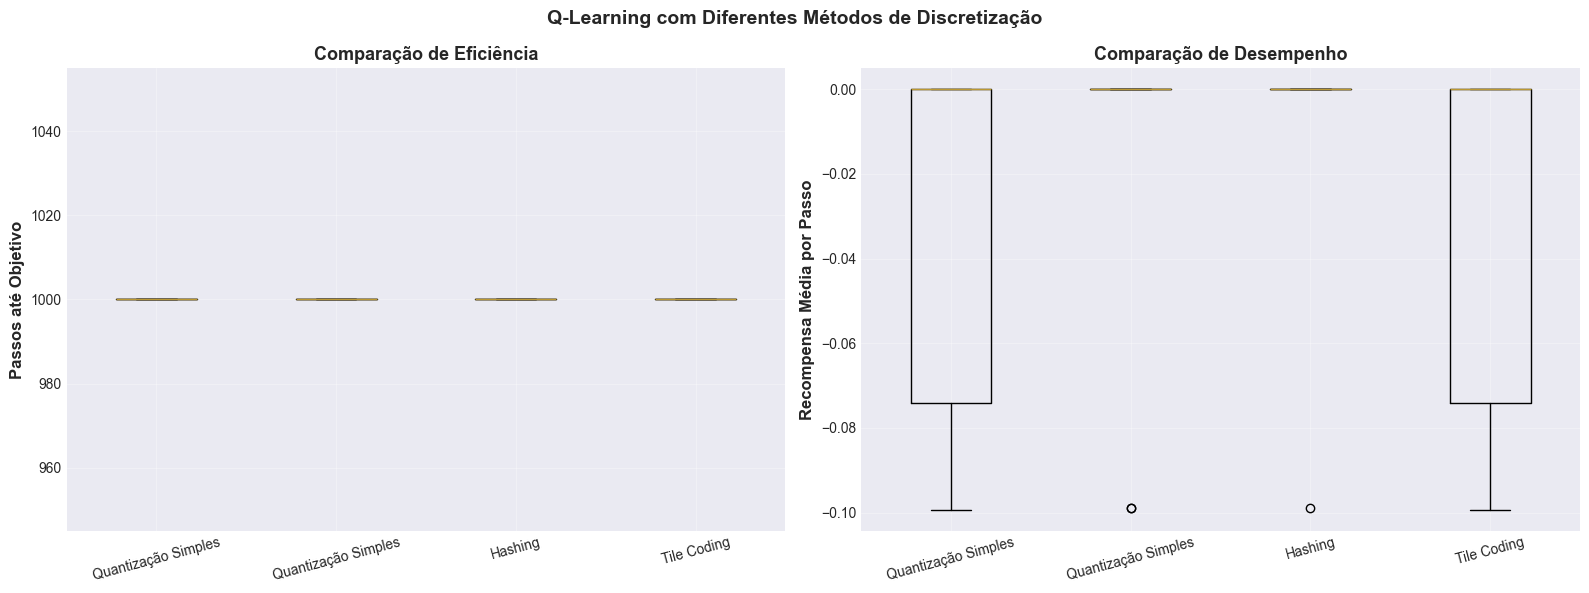

In [15]:
# Comparar resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Passos
step_data = [results[name]['steps'] for name, _ in quantizers]
axes[0].boxplot(step_data, labels=[name.split('(')[0].strip() for name, _ in quantizers])
axes[0].set_ylabel('Passos até Objetivo', fontsize=12, weight='bold')
axes[0].set_title('Comparação de Eficiência', fontsize=13, weight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=15)

# Recompensas
reward_data = [results[name]['rewards'] for name, _ in quantizers]
axes[1].boxplot(reward_data, labels=[name.split('(')[0].strip() for name, _ in quantizers])
axes[1].set_ylabel('Recompensa Média por Passo', fontsize=12, weight='bold')
axes[1].set_title('Comparação de Desempenho', fontsize=13, weight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.suptitle('Q-Learning com Diferentes Métodos de Discretização', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

## 10. Conclusões e Respostas às Questões

### Como simplificar estados contínuos para índices?

Existem várias abordagens:

1. **Quantização Simples**: Dividir cada dimensão em bins discretos
   - Simples de implementar
   - Número de estados cresce exponencialmente com dimensões
   - Pode criar muitas colisões se bins forem grandes

2. **Hashing**: Usar função hash para mapear perceções
   - Tamanho da tabela controlável
   - Colisões aleatórias podem afetar aprendizagem
   - Não preserva similaridade entre estados

3. **Tile Coding**: Múltiplas camadas de quantização deslocadas
   - Melhor generalização entre estados similares
   - Mais robusto a ruído
   - Mais complexo de implementar

### Quais são os riscos?

1. **Perda de Informação**: Estados diferentes mapeiam para o mesmo índice
2. **Ambiguidade**: O agente não consegue distinguir estados com perceções similares
3. **Política Subótima**: Ações ótimas podem ser diferentes para estados colapsados
4. **Exploração Ineficiente**: Colisões podem criar loops de aprendizagem

### Problema das Colunas 3 e 8:

- Estados simétricos em relação às paredes verticais
- Perceções podem ser idênticas ou muito similares
- **Risco crítico**: Ações ótimas são diferentes (um deve ir para esquerda, outro para direita)
- O agente aprende uma política média que não é ótima para nenhum dos casos

### Soluções Possíveis:

1. **Aumentar granularidade**: Mais bins, menos colisões (mas mais memória)
2. **Adicionar features**: Incluir posição absoluta estimada
3. **Function approximation**: Usar redes neurais em vez de tabelas Q
4. **Memória de trajetória**: Considerar histórico de perceções
5. **Tile coding**: Melhor generalização com múltiplas resoluções

## 11. Resumo Comparativo Final

In [16]:
# Tabela comparativa final
print("\n" + "="*100)
print("RESUMO COMPARATIVO DOS MÉTODOS DE DISCRETIZAÇÃO")
print("="*100)
print(f"{'Método':<30} {'Índices Max':<15} {'Colisões Médias':<20} {'Passos (Teste)':<20}")
print("-"*100)

methods_info = [
    ("Quantização Simples (5 bins)", quantizer, simple_collisions),
    ("Hashing (1000)", hash_quantizer, hash_collisions),
    ("Tile Coding (4x5)", tile_coder, tile_collisions)
]

for name, quant, collisions in methods_info:
    max_idx = quant.max_index()
    avg_collision = np.mean(collisions)
    
    # Encontra resultado correspondente
    matching_result = None
    for result_name in results:
        if name.split('(')[0].strip() in result_name:
            matching_result = results[result_name]
            break
    
    if matching_result:
        avg_steps = np.mean(matching_result['steps'])
        std_steps = np.std(matching_result['steps'])
        steps_str = f"{avg_steps:.1f} ± {std_steps:.1f}"
    else:
        steps_str = "N/A"
    
    print(f"{name:<30} {max_idx:<15} {avg_collision:<20.2f} {steps_str:<20}")

print("="*100)
print("\nOBSERVAÇÕES:")
print("- Menos colisões geralmente resulta em melhor desempenho")
print("- Tile Coding oferece melhor compromisso entre memória e precisão")
print("- Hashing pode ser problemático devido a colisões aleatórias")
print("- Granularidade deve ser ajustada ao problema específico")
print("="*100)


RESUMO COMPARATIVO DOS MÉTODOS DE DISCRETIZAÇÃO
Método                         Índices Max     Colisões Médias      Passos (Teste)      
----------------------------------------------------------------------------------------------------
Quantização Simples (5 bins)   1296            1.78                 1000.0 ± 0.0        
Hashing (1000)                 1000            1.74                 1000.0 ± 0.0        
Tile Coding (4x5)              5184            1.78                 1000.0 ± 0.0        

OBSERVAÇÕES:
- Menos colisões geralmente resulta em melhor desempenho
- Tile Coding oferece melhor compromisso entre memória e precisão
- Hashing pode ser problemático devido a colisões aleatórias
- Granularidade deve ser ajustada ao problema específico
